# Bayesian analysis of the empirical saturation point (refactored version)

In [4]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

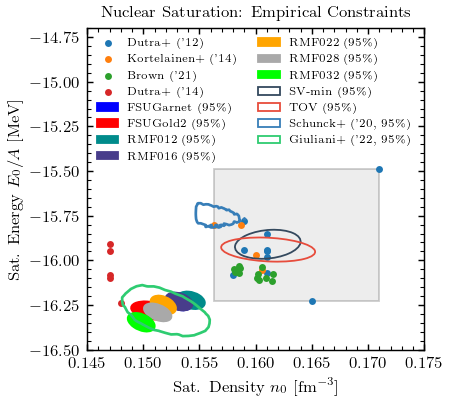

In [2]:
from modules.SaturationAnalysis import SaturationAnalysis
analysis = SaturationAnalysis()
analysis.plot_constraints(eft=False, eft_conf_level=0.95)

## Priors

Let's take a look at the priors used in this work. They can be specified in the file `modules/priors.py`.

In [ ]:
from modules.SaturationAnalysis import visualize_priors
from modules.priors import *
fig, axs = visualize_priors(used_prior_sets)
fig.savefig("prior_sets.pdf")

We use an uninformed prior (left) and an informed prior (right) and something in between (center panel) to investigate the prior sensitivity of our Bayesian inference.

## Saturation box in Drischler et al. (2016)
### Apply our statistical model directly

In [ ]:
from modules.SaturationAnalysis import drischler_satbox
drischler_satbox.plot(plot_box_estimate=True)

In [ ]:
from modules.StatisticalModel import StatisticalModel
use_prior_params = setB_prior_params
model = StatisticalModel(data=drischler_satbox.data_frame, prior_params=use_prior_params)
fig, _ = model.plot_predictives(validate=False)
fig.savefig("analysis_satbox_2016.pdf")

In [ ]:
ret = model.plot_predictives_corner()
import matplotlib.backends.backend_pdf
pdf = matplotlib.backends.backend_pdf.PdfPages(f"pdf/corner_plot_{use_prior_params['label']}.pdf")
for elem in ret:
    fig, axs = elem
    pdf.savefig(fig)
pdf.close()

Generting the corner plot did not require any sampling of the distribution functions. Only (semi-)analytic calculations. Let's check our implementation brute-force using sampling:

In [ ]:
ret = model.plot_predictives_corner_bf()
import matplotlib.backends.backend_pdf
pdf = matplotlib.backends.backend_pdf.PdfPages(f"pdf/corner_plot_bf_{use_prior_params['label']}.pdf")
for elem in ret:
    fig, axs = elem
    pdf.savefig(fig)
pdf.close()

The results match. However, the Python package `corner` has a known bug. The percentiles in the titles are always the default ones. We have fixed the issue by computing the percentiles separately. The percentiles above correspond to the 95% confidence level.

In [ ]:
model.posterior_params

### Alternative: use a single Monte Carlo step

In [ ]:
from modules.DataSets import DataSetSampleConfig, Scenario
from modules.SaturationAnalysis import drischler_satbox
from modules.priors import standard_prior_params

config = DataSetSampleConfig(data_set=drischler_satbox)
config.sample_kwargs["num_points"] = None  # use all points for the analysis
print(config)
scenarioX = Scenario(
    label="Drischler Satbox",
    configs=[config]
)

analysis.multiverse(
    scenarioX,
    num_realizations=1,
    prior_params=use_prior_params,
    debug=False,
    plot_fitted_conf_regions=True
)

## Hierarchical model

In [ ]:
from modules.DataSets import DataSetSampleConfig, Scenario
from modules.SaturationAnalysis import DEFAULT_DFT_CONSTRAINTS as dft_constraints
scenario1 = Scenario(
    label="FSU-only",
    configs=[DataSetSampleConfig(data_set=dft_constraints["FSU"])]
)

scenario2 = Scenario(
    label="FSU+Schunck-only",
    configs=[
        DataSetSampleConfig(
            data_set=dft_constraints["FSU"]
        ),
        DataSetSampleConfig(
            data_set=dft_constraints["Schunck"]
        )
    ]
)
scenario3 = Scenario(
    label="all-but-FSU",
    configs=[
        DataSetSampleConfig(
            data_set=dft_constraints[lbl]
        ) for lbl in dft_constraints.keys() if lbl != "FSU"
    ]
)
scenario4 = Scenario(
    label="Giuliani+Schunck-only",
    configs=[DataSetSampleConfig(
        data_set=dft_constraints["Giuliani"]
    ),
        DataSetSampleConfig(
            data_set=dft_constraints["Schunck"]
        )
    ]
)
# scenario1.configs[0].data_set.plot()

In [ ]:
analysis.multiverse(scenario3, num_realizations=1000,
                    num_samples_mu_Sigma=10000,
                    prior_params=setA_prior_params)

In [ ]:
analysis.multiverse(scenario3, num_realizations=1000,
                    num_samples_mu_Sigma=10000,
                    prior_params=setB_prior_params)

In [ ]:
analysis.plot_individual_models()

## EFT predictions for the nuclear saturation point

In [ ]:
from modules.plot_helpers import cm
import matplotlib.pyplot as plt
from modules.eft_satpoints import make_coester_plot
fig, ax = plt.subplots(1, 1, figsize=(8.6*cm, 8.6*cm), constrained_layout=True)
make_coester_plot(ax,
                  #emp_constraint=drischler_satbox.box_estimate().update({"type": "box"})
                  emp_constraint={"type": "t", **model.predictives_params(return_dict=True)}
                  )
fig.savefig("pdf/eft_satpoints.pdf")

## Symmetry energy at saturation density

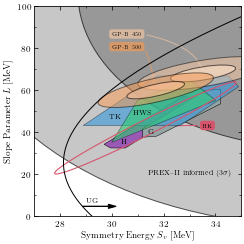

In [43]:
from modules.plot_helpers import cm
from modules.symmetry_energy import make_sv_l_plot
import matplotlib.pyplot as plt
fig, axs = plt.subplots(1, 1, figsize=(8.6*cm, 8.6*cm), constrained_layout=True)
make_sv_l_plot(axs)
fig.savefig("pdf/esym.pdf")